In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy.signal as scs

def sg_filter(y:np.array, Len:int, Degree:int)->np.array:
    return scs.savgol_filter(y,Len,Degree)

def conv_filter(y:np.array, kernel:np.array)->np.array:
    ### Truncate convolved signal
    y_clean = np.convolve(y,kernel,mode='same')
    n_cut = int(kernel_len/2)
    y_clean[:n_cut] = np.nan
    y_clean[-n_cut:] = np.nan
    return y_clean

def butter_filter(y:np.array,cut_frequency:float,sampling_frequency:float)->np.array:
    sos = scs.butter(1,cut_frequency,btype='low',output='sos',fs=sampling_frequency)
    return scs.sosfilt(sos,y)

def median_filter(y:np.array,window_length:int)->np.array:
    return scs.medfilt(y,window_length)

def wiener_filter(y:np.array,window_length:int)->np.array:
    return scs.wiener(y,window_length)

def bell_curve(n:int,mu:int,sigma:int)->np.array:
    x_tail = int(n/2)
    x = np.linspace(mu-x_tail,mu+x_tail,n)
    a = (x-mu)**2/(2*sigma**2)
    b = np.exp(-a)
    c = np.sqrt(2*np.pi*sigma**2)
    kernel = b/c
    return (kernel/sum(kernel),x)

def find_tau(df,Fs):
    dfn = df - df[0]
    EPS = 2*df.std()/Fs
    return dfn.index[dfn.abs()<EPS].tolist()[-1]

SEED = [20071105,19761129]

Fs = 10

Tau_ramp = 9.1

Per = 9.2
Tau = 2.5*Per+1.2
Amp, Freq = 12.0, 1/12.2

np.random.seed(SEED[0])

amp_noise =  22e-2*Amp

MN = 6
kernel_len = int(MN*Fs)+1
kernel,xk = bell_curve(kernel_len,0,int(kernel_len/MN/3))

#Phase = np.random.rand()*2*np.pi
Phase = 0./6.0*np.pi

t_ramp = np.arange(0,Tau_ramp,1/Fs)

Y0 = -1/2*Amp
X1,Y1 = Tau_ramp,Amp*np.sin(Phase)

alf = (Y1-Y0)/X1
bet = Y0

y_ramp = alf*t_ramp + bet

t= np.arange(0,Tau,1/Fs)

y = Amp*np.sin(2*np.pi*Freq*t+Phase)
y = np.append(y_ramp,y)
y = y - Y0
t = np.append(t,np.arange(Tau,Tau+Tau_ramp,1/Fs))

yNoise = (1/2-np.random.rand(len(t)))*amp_noise
y_noisy = y + yNoise


signals = {
    'original' : y,
    'noise'    : y_noisy,
    'convol'   : conv_filter(y_noisy,kernel),
    'savgol'   : sg_filter(y_noisy,int(3*Fs),2),
    'median'   : median_filter(y_noisy,11),
    'wiener'   : wiener_filter(y_noisy,11)
}

df = pd.DataFrame(signals, index = t)

### Signal truncation to equal periods
Tau = find_tau(df['original'],Fs)

k = df.index<Tau
dfn = df[k]

lines_w = {'original': 4.0, 'noise': 0.5, 'convol': 1.0,'savgol': 1.0, 'median': 1.0,'wiener': 1.0}
alpha_w = {'original': 0.5, 'noise': 1.0, 'convol': 1.0,'savgol': 1.0, 'median': 1.0,'wiener': 1.0}

residuals = {
    'noise'  : y_noisy-y,
}

for c in ['convol','savgol','median','wiener']:
    residuals[c] = signals[c] - y

title = ['signal','error']

dfr = pd.DataFrame(residuals)
dfr.index = t

st_dev = dfr['noise'].dropna(axis=0).std()/2


# Plot kernel of convolution filter

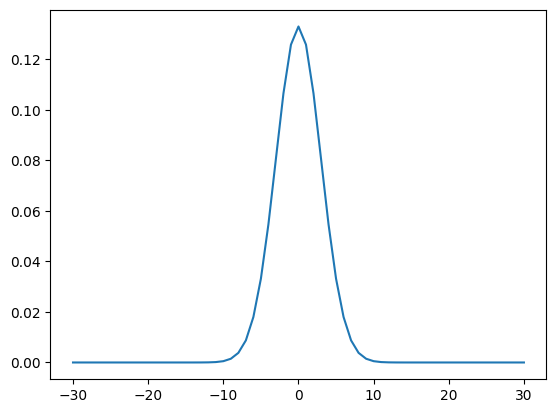

In [ ]:
fig,ax = plt.subplots()
ax.plot(xk,kernel)

# Plot results of filtering

noise     0.761700
convol    0.239947
savgol    0.320668
median    0.378089
wiener    0.333599
dtype: float64


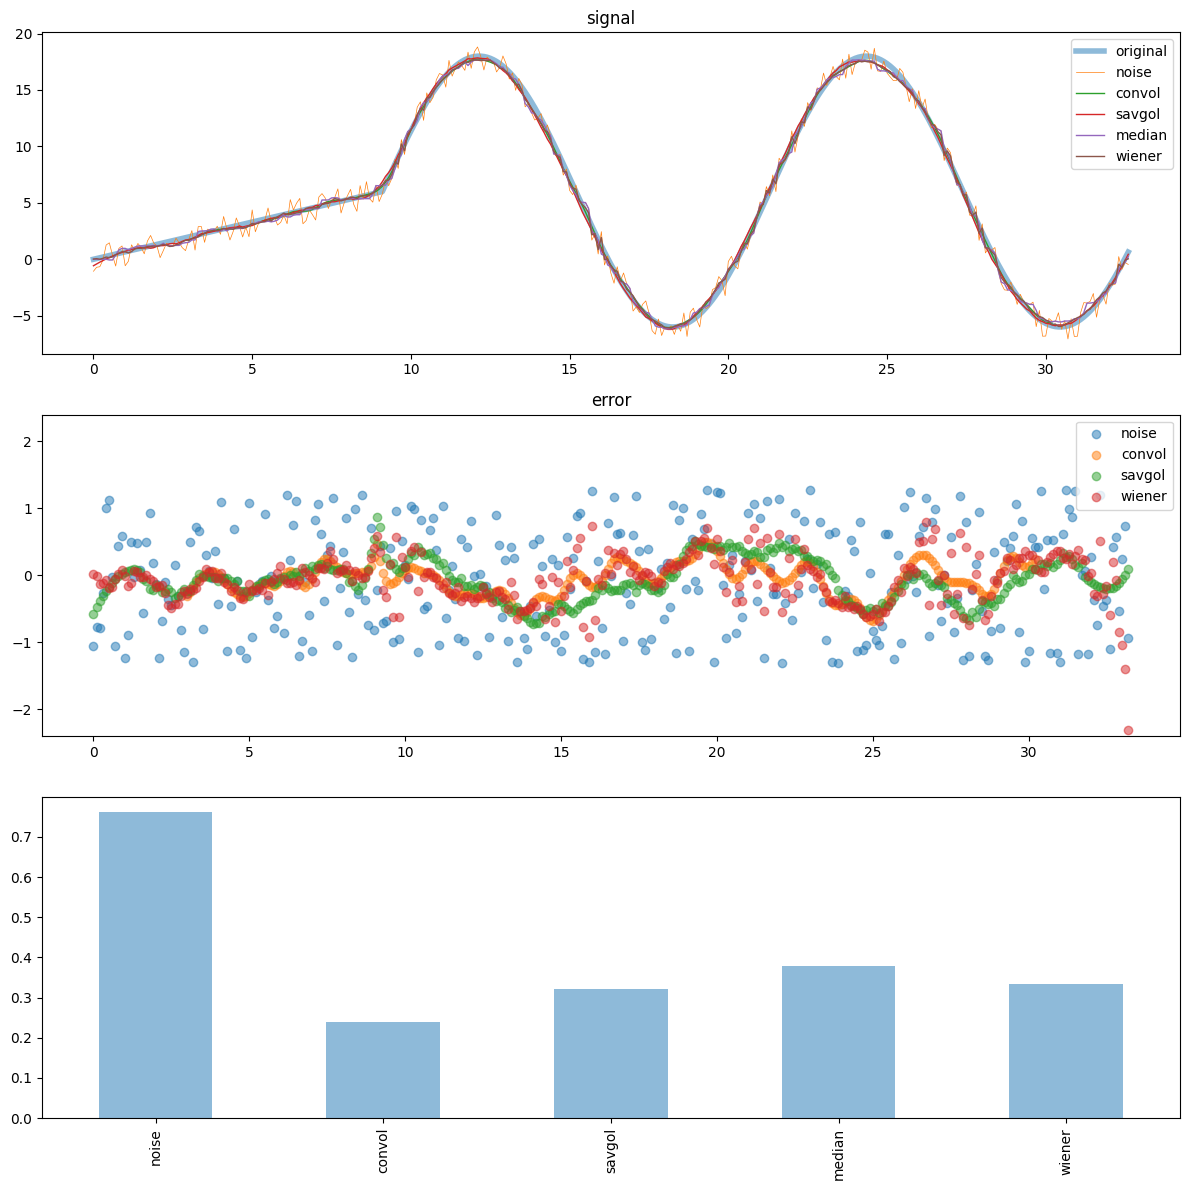

In [ ]:

fig,(axt,axn,axb) = plt.subplots(3,figsize=(9,9))

for c in residuals:
    if (dfr[c].dropna(axis=0).std() < st_dev) | (c == 'noise'):
        axn.set_title(title[1])
        axn.scatter(t,residuals[c],label=c,alpha=.5,lw=1)
axn.set_ylim(-.2*Amp,.2*Amp)

for c in dfn.columns:
    axt.set_title(title[0])
    axt.plot(dfn[c],label=c,lw=lines_w[c],alpha=alpha_w[c])

dfs = dfr.dropna(axis=0).std()
dfs.plot.bar(alpha=.5)

axt.legend()
axn.legend()

fig.tight_layout()

print(dfs)